In [1]:
#@title ######ACCESO A GOOGLE DRIVE { display-mode: "form" }
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title ######LIBRERIAS GENERALES { display-mode: "form" }

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, models, utils
from torch import nn, random
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision
import sklearn
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from torchsummary import summary
import math
from matplotlib.backends.backend_pdf import PdfPages
from random import randint, uniform,random
import pandas as pd
from sklearn.metrics import accuracy_score
import os


np.random.seed(0)

# **MENÚ DE SELECCIÓN**

---



In [3]:
#@title **ANÁLISIS - PATÓGENO:** { form-width: "500px" }
# Parametros de carga de datos segun estructura de carpetas en Google Drive y expotacion a PDF:

tipo_analisis = 'Aguas - Clasificacion' #@param ["Aguas - Clasificacion",'Aguas - Deteccion', "Challenge - Clasificacion",'Challenge - Deteccion',"Producto Terminado - Clasificacion"]{allow-input: true}
tipo_patogeno = 'Burkholderia Cepacia' #@param ["Aspergillus Brasiliensis","Burkholderia Cepacia", "Candida Albicans","Escherichia Coli","Pseudomonas Aeruginosa","Staphylococcus Aureus","Aerobios Mesofilos","Mohos y levaduras",'Todas']{allow-input: true}

Entrenar_modelo = False #@param {type:"boolean"}
#Validar_modelo = False #@param {type:"boolean"}
path_modelos_entrenados = f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/"
path_modelos_entrenados = os.listdir(path_modelos_entrenados)
print(path_modelos_entrenados)

# tipo analisis:
#   1. Aguas - Deteccion
#   2. Challenge - Deteccion
#   3. Producto Terminado - Clasificacion

# tipo patogeno:
#   1. Candida Albicans
#   2. Aerobios Mesofilos
#   3. Burkholderia Cepacia
#   4. Mohos y levaduras
#   5. Aspergillus Brasiliensis
#   6. Staphylococcus Aureus
#   7. Escherichia Coli
#   8. Staphylococcus Aureus
#   9. Pseudomonas Aeruginosa

['688-AG-BC.pt']


In [4]:
if Entrenar_modelo == False:
  Nombre_Fichero_modelo_a_validar =  "688-AG-BC.pt" #@param {type:"string"}
  id = Nombre_Fichero_modelo_a_validar.split('-')[0]

  print(Nombre_Fichero_modelo_a_validar)
  



688-AG-BC.pt


In [5]:
#@title **HIPERPARÁMETROS:** { output-height: 100, display-mode: "form" }
batch_size = 10 #@param {type:"slider", min:0, max:100, step:1}
batch_size_test = 1 #@param {type:"slider", min:0, max:100, step:1}
n_epochs = 22 #@param {type:"slider", min:0, max:50, step:1}
dim_img_ini = 256 #@param ["16", "32", "64", "128", "256", "512", "884"] {type:"raw"}


# Parametros Red Neuronal:

# learning_rate = 0.001 # Paso de aprendizaje  
# n_epochs = 25 # Numero de epocas de entrenamiento 
# batch_size_test = 1 # Muestras por lote de testeo TODO
# dim_img_ini = 256
# conv_ini = 128
# red_preEntrenada = 1
# model_preTrain = 'resnet' #resnet'

In [6]:
#@title **PARÁMETROS - OPTIMIZADOR:**
learning_rate = 0.001 #@param {type:"slider", min:0, max:0.25, step:0.01}
momentum = 0.9 #@param {type:"slider", min:0.5, max:1, step:0.05}
weight_decay = 0.0005 #@param {type:"number"}

In [7]:
#@title **ARQUITECTURA RED:**
model_preTrain = 'resnet18' #@param ["resnet18","resnet34","resnet50","inception", "densenet", "squeze", "Nuevo"] {type:"string"}
conv_ini = 128 #@param ["16", "32", "64", "128", "256", "512"] {type:"raw"}

In [8]:
#@title ##### IDENTIFICADOR SELECCIÓN
if tipo_analisis == "Challenge - Clasificacion":
  id_analisis = "CH"

elif tipo_analisis == "Aguas - Clasificacion":
  id_analisis = "AG"

elif tipo_analisis == "Producto Terminado - Clasificacion":
  id_analisis = "PT"

elif tipo_analisis == "Challenge - Deteccion":
  id_analisis = "CH"

if tipo_patogeno == "Candida Albicans":
  id_patogeno = "CA"
elif tipo_patogeno == "Burkholderia Cepacia":
  id_patogeno ="BC"
elif tipo_patogeno == "Aspergillus Brasiliensis":
  id_patogeno ="AB"
elif tipo_patogeno == "Escherichia Coli":
  id_patogeno ="EC"
elif tipo_patogeno == "Pseudomonas Aeruginosa":
  id_patogeno = "PA"
elif tipo_patogeno == "Staphylococcus Aureus":
  id_patogeno ="SA"
elif tipo_patogeno == "Todas":
  id_patogeno ="Todas"

print(id_analisis, id_patogeno)

AG BC


# **DIVIDIR DATASET EN TRAINING, VALIDATION Y TEST**

---



**FUNCION SPLIT**

In [9]:
def load_split_train_test(datadir, valid_size = .1, batch_size= batch_size,dim_img_ini=dim_img_ini):
  from torch.utils.data.sampler import SubsetRandomSampler

  # Transformaciones
  mean = np.array([0.5, 0.5, 0.5])  # TODO
  std = np.array([0.5, 0.5, 0.5])  # TODO 

  train_transforms = transforms.Compose([        
      transforms.Resize(dim_img_ini),  
      transforms.ToTensor(),  
      transforms.Normalize(mean, std)])
  
  test_transforms = transforms.Compose([        
      transforms.Resize(dim_img_ini),  
      transforms.ToTensor(),  
      transforms.Normalize(mean, std)])
  
  # Datasets + Transformaciones
  train_data = datasets.ImageFolder(datadir,       
                  transform=train_transforms)
  test_data = datasets.ImageFolder(datadir,
                  transform=test_transforms)

  len_data = len(train_data)
  indices = list(range(len_data))
  np.random.seed(0)
  np.random.shuffle(indices)

  # Split train y test
  split_train_test = int(np.floor(valid_size * len_data))
  train_idx_aux = indices[split_train_test:]
  test_idx = indices[:split_train_test]

  # Split train y valid
  split_train_valid = int(np.floor(valid_size * len(train_idx_aux)))
  train_idx = train_idx_aux[split_train_valid:]
  valid_idx = train_idx_aux[:split_train_valid]

  # Samplers
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  # Loaders
  train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)

  valid_loader = torch.utils.data.DataLoader(train_data, 
                                            batch_size=batch_size,
                                            sampler=valid_sampler)

  test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=1,
                                            sampler=test_sampler)

  
  return train_loader,valid_loader,test_loader, train_data



**LLAMADA A LA FUNCION**

In [10]:
data_dir = f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/dataset_entrenamiento"  # Ruta de carpeta que contiene las clases TODO


In [11]:
train_loader,valid_loader,test_loader,train_data = load_split_train_test(data_dir, .1,batch_size,dim_img_ini)

print("Dataset total:",len(train_data))
print("Dataset entrenamiento:",len(train_loader.sampler))
print("Dataset test:",len(test_loader.sampler))
print("Dataset validacion:",len(valid_loader.sampler))

Dataset total: 15
Dataset entrenamiento: 13
Dataset test: 1
Dataset validacion: 1


**ANALISIS DE CONTENIDO DATASET**

In [12]:
def ver_contenido_Dataset(dataset):
  '''
  INPUT: dataset = dataset.ImageFolder(...)
  '''

  # Identificacion de clases
  clases = dataset.classes
  n_clases = len(clases)
  print("Clases existentes:",clases)
  print("Cantidad de clases:", n_clases)

  # Cantidad de imagenes por clase.
  num_img = []
  cantidad_imagenes_por_clase=[]
  for i in range(n_clases):
    num_img.append([])

    for target in dataset.targets:
      if target==i:
        num_img[i].append(target)

    cantidad_imagenes_por_clase.append(len(num_img[i]))
    print(f"Nº imagenes en clase {clases[i]}: {len(num_img[i])}")

  # Barplot clases-cantidadImagenes
  df = pd.DataFrame({'Clases':clases, 'Nº Imagenes':cantidad_imagenes_por_clase})
  ax = df.plot.bar(x='Clases', y='Nº Imagenes', rot=0,figsize=(15,10),legend=False,grid=True,fontsize=20, width=0.25)
  ax.set_xlabel("Clases",fontsize=15)
  ax.set_ylabel("Nº Imagenes",fontsize=15)
  ax.set_title("Cantidad de imagenes por clase", fontsize=18)

  return clases, n_clases

Clases existentes: ['AUSENCIA', 'PRESENCIA']
Cantidad de clases: 2
Nº imagenes en clase AUSENCIA: 8
Nº imagenes en clase PRESENCIA: 7


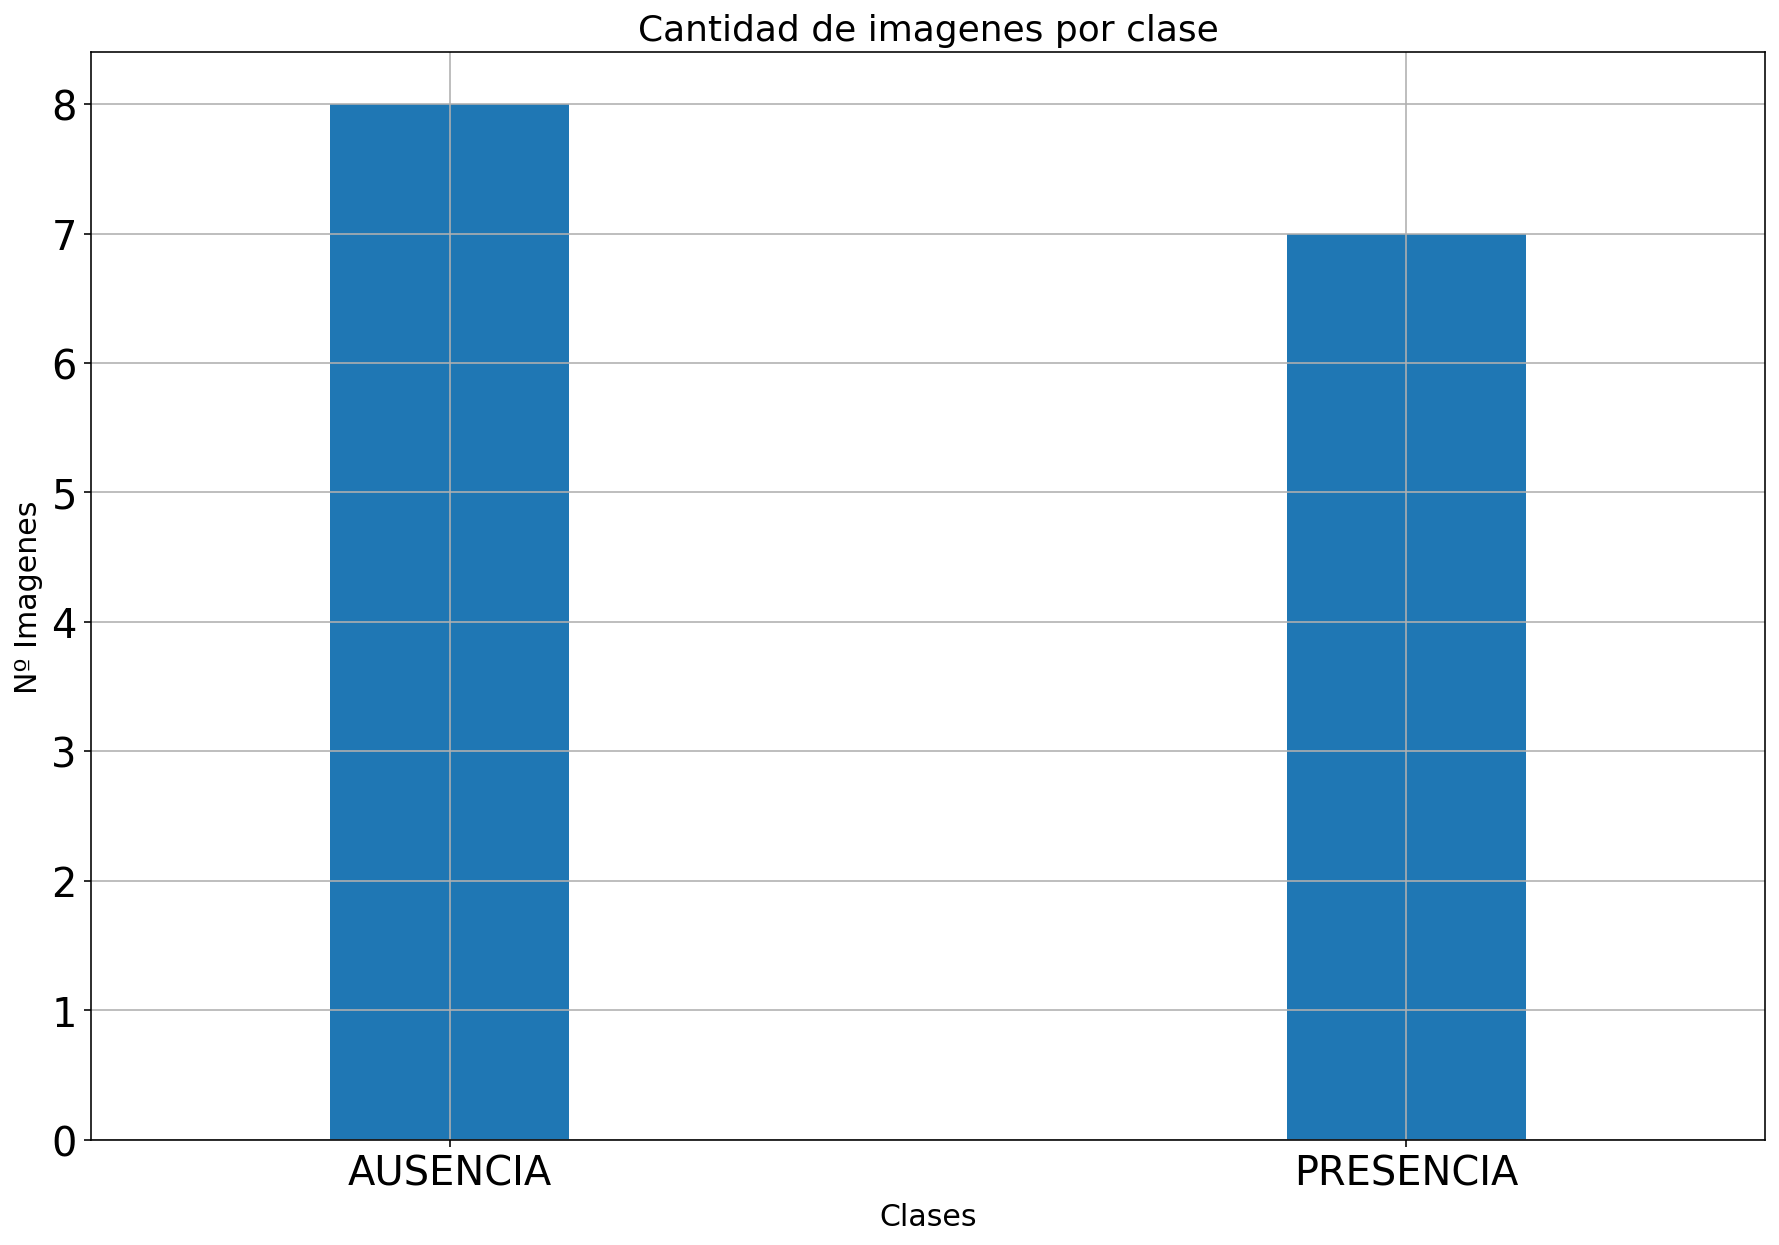

In [13]:
clases, n_clases = ver_contenido_Dataset(train_data)

**PLOT DE IMAGENES**

In [14]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()  
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show

In [15]:
# Obtencion de un batch de las imagenes de entrenamiento:

# fig = plt.figure(figsize=(16, 9))
# for i in range(4):
#   j=randint(1,len(train_data))
#   img, ann= train_data[j]
#   ax = fig.add_subplot(1,4, i + 1, xticks=[], yticks=[])
#   imshow(img)
#   ax.set_title(clases[ann])   
      

# **MODELO DE LA RED NEURONAL**

---



In [16]:
#@title ####MODELO PROPIO

if model_preTrain == 'Nuevo':

  # Definimos la red neuronal convolucional:
  class Net(nn.Module):
      def __init__(self):
          global conv_fin,dim_img_fin, dim_img_ini, conv_ini
          super(Net, self).__init__()

          # Capa convolucional de entrada (profundidad imagen entrada, profundidad imagen salida, kernel, padding, stride) --> 800 x 800 x 3
          conv_ini = conv_ini
          self.conv1 = nn.Conv2d(3, conv_ini, 3, padding=1)  # TODO
          conv_fin = conv_ini
          dim_img_fin = int(dim_img_ini/2)

          # Capa convolucional --> 400 x 400 x 64
          self.conv2 = nn.Conv2d(conv_ini, 2*conv_ini, 3,padding=1)  # TODO
          conv_fin =  2*conv_ini
          dim_img_fin = int(dim_img_fin/2)

          #Capa convolucional --> 200 x 200 x 128
          self.conv3 = nn.Conv2d(2*conv_ini, 4*conv_ini, 3,padding=1)  # TODO
          conv_fin =  4*conv_ini
          dim_img_fin = int(dim_img_fin/2)

          # Max pooling (Kernel, stride)
          self.pool = nn.MaxPool2d(2, 2)  # TODO

          # Capa fully conected
          self.fc1 = nn.Linear(conv_fin * dim_img_fin *dim_img_fin,1000 )  # TODO

          # Capa fully conected salida (tamaño, numero de clases)
          self.fc2 = nn.Linear(1000, n_clases)  # TODO

          # Abandono --> Evitar overfitting
          self.dropout = nn.Dropout(0.25)  # TODO

      def forward(self, x):
          # Secuencia de capas convolucionales y max pooling
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))

          # Se aplana la matriz --> Vector
          x = x.view(-1, conv_fin * dim_img_fin *dim_img_fin)  # TODO

          # Capa de abandono
          x = self.dropout(x)

          # Capa oculta con Relu
          x = F.relu(self.fc1(x))

          # Capa de abandono
          x = self.dropout(x)

          # Capa oculta de salida con Relu
          x = self.fc2(x)

          return x

  model=Net()


In [17]:
#@title ####MODELO PRE-ENTRENADO

if model_preTrain != 'Nuevo':  

 # Definicion del modelo
  if model_preTrain == 'resnet50':
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, n_clases)

  elif model_preTrain == 'resnet18':
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, n_clases)

  elif model_preTrain == 'resnet34':
    model = models.resnet34(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, n_clases)

  elif model_preTrain =='inception':
    model = models.inception_v3(pretrained=True)
    model.aux_logits=False
    # Handle the auxilary net
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs, n_clases)
    # Handle the primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,n_clases)
    dim_img_ini = 299


  elif model_preTrain == "densenet":    
    model = models.densenet121(pretrained=True)
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, n_clases)
    dim_img_ini = 224

  elif model_preTrain == 'squeze':
    model = models.squeezenet1_0(pretrained=True)
    model.classifier[1] = nn.Conv2d(512, n_clases, kernel_size=(1,1), stride=(1,1))
    model.num_classes = n_clases
    dim_img_ini = 224

  elif model_preTrain == 'resnext':
    model = models.resnext50_32x4d(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, n_clases)




# **DISPONIBILIDAD GPU/CPU**

---



In [18]:
def disponibilidad_gpu(model):

  # Comprobamos si la GPU esta disponible:
  train_on_gpu = torch.cuda.is_available()
  print("DISPOSITIVO DE ENTRENAMIENTO:\n")
  if not train_on_gpu:
      print("CUDA no esta disponible. Entrenando en CPU...\n\n")
  else:
      print("CUDA disponible! Entrenando en GPU...\n\n")

  # Movemos la red a CUDA si esta disponible:
  if train_on_gpu:
    model.cuda()

    return model, train_on_gpu

model, train_on_gpu = disponibilidad_gpu(model)

# Mostramos la arquitectura de la red
print("ARQUITECTURA DE LA RED:")
summary(model, input_size=(3, dim_img_ini, dim_img_ini)) # Chanels, height, width


DISPOSITIVO DE ENTRENAMIENTO:

CUDA disponible! Entrenando en GPU...


ARQUITECTURA DE LA RED:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      Ba

# **FUNCION DE PERDIDA Y OPTIMIZADOR**

---



In [19]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizador TODO
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()  # Funcion de perdida TODO

# **ENTRENANDO LA RED NEURONAL**

---



In [20]:
id = randint(0,1000)

if Entrenar_modelo:
  valid_loss_min = np.Inf  # Perdida acumulada infinita para guardar el modelo
  train_losses,valid_losses,accuracys =[],[],[]

  start = time.time()

  print("INICIO DE ENTRENAMIENTO:\n")


  for epoch in range(1,n_epochs+1):

      # Inicializamos valores:
      train_loss = []
      valid_loss = []
      
      ##################
      # train de model #
      ##################

      model.train()

      for data, target in train_loader:
          # Movemos los tensores a la GPU si esta disponible:
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()

          # Ponemos los gradientes a 0:
          #optimizer.zero_grad()
          for p in model.para,eters(): p.grad = None

          # Forward pass: Se obtienen las predicciones del modelo:
          output = model(data)

          # Se calcula la pérdida:
          loss = criterion(output, target)
          train_loss.append(loss.item())

          # Se realiza el backpropagation (descenso del gradiente):
          loss.backward()

          # Se actualiza el valor de los pesos
          optimizer.step()

    

      ######################
      # validate de model #
      #####################

      model.eval()
      correct= 0
      total = 0
      accuracy = 0 
      for data, target in valid_loader:
          # Movemos los tensores a la GPU si esta disponible:
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()

          # Forward pass: Se obtienen las predicciones del modelo:
          output = model(data)
          _, pred= torch.max(output.data,1)

          # Se calcula la pérdida:
          loss = criterion(output, target)
          valid_loss.append(loss.item())       

          
          # Accuracy        
          total += target.size(0)
          correct += (pred == target).sum().item()   
          acc =  100*correct/float(total)            

      # Calculamos la media de perdidas y la precision por epoca:
      train_losses.insert(epoch,np.mean(train_loss))
      valid_losses.insert(epoch,np.mean(valid_loss))
      accuracys.insert(epoch,acc)

      # Mostramos las estadisticas de entrenamiento y validacion:
      print ("Epoch: {}/{}    Training Loss: {:.6f}     Validation Loss: {:.6f}     Accuracy: {:.4f} %".format( epoch,n_epochs, np.mean(train_loss), np.mean(valid_loss),acc))

      # Guardamos el modelo si la perdida de validacion disminuye:
      if np.mean(valid_loss) <= valid_loss_min:
        epoch_best_model = epoch      
        torch.save(model.state_dict(), f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/{id}-{id_analisis}-{id_patogeno}.pt")
        valid_loss_min = np.mean(valid_loss)

        # checkpoint = {'model': Net(),
        #     'state_dict': model.state_dict(),
        #     'optimizer' : optimizer.state_dict()}

        # torch.save(checkpoint, f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/{id}-{id_analisis}-{id_patogeno}.pth")

  end = time.time()

  segundos = (end - start)
  horas=int(segundos/3600)
  segundos-=horas*3600
  minutos=int(segundos/60)
  segundos-=minutos*60


  print(f'\nValidation loss minimun --> Epoch: {epoch_best_model} -->  Model saved ')  

  print("\nFIN DEL ENTRENAMIENTO\n  ")

  print("Tiempo de entrenamiento: %s min %.2f sec" % (minutos,segundos))


In [21]:
#@title ####GRAFICO PERDIDAS TRAINING/VALIDACION - ACCURACY

if Entrenar_modelo:
  # Grafica Loss
  plt.figure(figsize=(10,6))
  plt.plot(range(1,n_epochs+1),train_losses, label = "Training Loss")
  plt.plot(range(1,n_epochs+1),valid_losses, label = "Validation Loss")
  plt.legend()
  plt.xlabel('Epochs',fontsize=15);
  plt.ylabel('Loss',fontsize=15);
  plt.title("Loss Training/validation", fontsize=18);
  plt.grid(True)
  plt.xlim(1,n_epochs);
  plt.xticks(fontsize=15);
  plt.yticks(fontsize=15);

  # Grafica Accuracy
  plt.figure(figsize=(10,6))
  plt.plot(range(1,n_epochs+1),accuracys, "r")
  plt.xlabel('Epochs',fontsize=15);
  plt.ylabel('%',fontsize=15);
  plt.title("Training Accuracy", fontsize=18);
  plt.grid(True)
  plt.xlim(1,n_epochs);
  plt.xticks(fontsize=15);
  plt.yticks(fontsize=15);


# **CARGANDO MEJOR MODELO ENTRENADO**

---




In [22]:
if Entrenar_modelo:
  Nombre_Fichero_modelo_a_validar = f'{id}-{id_analisis}-{id_patogeno}.pt'  
   
model.load_state_dict(torch.load(f"/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/Modelos entrenados/{Nombre_Fichero_modelo_a_validar}"))
print(model)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **TESTEANDO EL MEJOR MODELO ENTRENADO**

---



In [26]:
# Inicializamos variables:
test_loss = 0.0
class_correct = list(0. for i in range(n_clases))
class_total = list(0. for i in range(n_clases))
total = 0.0
correct_total=0.0
confusion_matrix = torch.zeros(n_clases, n_clases)
target_v,preds_v,data_v,prob_v=[],[],[],[]

model.eval()

y_pred_list = []
y_true_list = []

# Iteramos con el conjunto de datos de test:
for data, target in (test_loader):
  # Movemos los tensores a la GPU si esta disponible:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

  # Forward pass: Se obtienen las predicciones del modelo:
  start_time = time.time()
  output = model(data)
  end_time = time.time()
  print(f"Tiempo ejecucion deteccion:{(end_time - start_time):.4f} sec")
  print(output)
  


  y_test_pred = torch.log_softmax(output, dim=1)
  _, y_pred_tag = torch.max(y_test_pred, dim = 1)
  y_pred_list.append(y_pred_tag.cpu().numpy())
  y_true_list.append(target.cpu().numpy())

  # Convertimos las probabilidades a las clases predichas:
  _, pred = torch.max(output, 1)  
  preds = np.squeeze(pred.numpy()) if not train_on_gpu else np.squeeze(pred.cpu().numpy())

  # # Obtenemos los scores de cada imagen
  sm = torch.nn.Softmax()
  prob = sm(output) 
  prob, _ = torch.max(prob, 1)
  prob = np.squeeze(prob.numpy()) if not train_on_gpu else np.squeeze(prob.cpu().detach().numpy())
  prob = prob * 100
  np.set_printoptions(precision=2)
  np.set_printoptions(suppress=True)  

  # Comparamos predicciones por clase con lo verdadero:
  correct = (pred==target).squeeze()

  # Calculo precision por clase
  label = target        
  #class_correct[label] += correct[i].item()
  class_correct[label] += correct.item()
  class_total[label] += 1


  # Almacenamos en vectores los datos para plotearlos despues
  # data=data.cpu()    
  target_v.append(clases[target])
  preds_v.append(clases[preds])
  data_v.append(data) 
  prob_v.append(prob)

          
      
  # # Matriz de confusion
  for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1      
      


Tiempo ejecucion deteccion:0.0038 sec
tensor([[-8.5649,  7.5156]], device='cuda:0', grad_fn=<AddmmBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# **RESULTADOS DEL TEST**

In [24]:
#@title ####METRICAS { form-width: "500px" }
import itertools

def plot_classification_report(cr,n_clases , title='Informe clasificacion', with_avg_total=False, cmap='RdBu'):

    lines = cr.split('\n')
    

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) -n_clases+1 )]:
        #print(line)
        t = line.split()
        #print(t)
        classes.append(t[0])
        #print(classes)
        v = [float(x) for x in t[1: len(t) - 1]]
        #print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    plt.figure(figsize=(15,10))
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45, fontsize=10)
    plt.yticks(y_tick_marks, classes,fontsize=10)
    
    plt.tight_layout()
    plt.ylabel('Clases')
    plt.xlabel('Metricas')
    plt.tick_params(labelsize=12)

    plotMat = np.array(plotMat)
    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black",fontsize=17)
    

y_pred_list_ = [i[0] for i in y_pred_list]
y_true_list_ = [i[0] for i in y_true_list]

sample_classification_report = classification_report(y_true_list_, y_pred_list_,target_names=clases)
#print(sample_classification_report)

score = accuracy_score(y_true_list_, y_pred_list_)
print(f"Eficacia del modelo: {score*100:.2f} %")



#Mostramos la precision por clases y total:
print("\n\nRECALL/ACCURACY POR CLASES:\n")
for i in range(n_clases):
    print("Recall of %5s: %.2f %%  (%2d/%2d)" %(clases[i],100*class_correct[i]/class_total[i],np.sum(class_correct[i]),np.sum(class_total[i])))


# print("Accuracy of %5s: %.2f %%  (%2d/%2d)" %(clases[0],100*class_correct[0]/(class_correct[0]+(class_total[1]- class_correct[1])),np.sum(class_correct[0]), class_correct[0]+class_total[1]- class_correct[1]))
# print("Accuracy of %5s: %.2f %%  (%2d/%2d)" %(clases[1],100*class_correct[1]/(class_correct[1]+(class_total[0]- class_correct[0])),np.sum(class_correct[1]), class_correct[1]+class_total[0]- class_correct[0]))

Accuracy_tot = 100 *np.sum(class_correct)/np.sum(class_total) ,np.sum(class_correct),np.sum(class_total)
print(f"\nTotal Accuracy: %.2f %% (%2d/%2d)\n" %(Accuracy_tot))

plot_classification_report(sample_classification_report,n_clases,with_avg_total=True)


Eficacia del modelo: 0.00 %


RECALL/ACCURACY POR CLASES:

Recall of AUSENCIA: 0.00 %  ( 0/ 1)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ZeroDivisionError: ignored

In [ ]:
#@title ####MATRIZ DE CONFUSION
# plot confussion matrix
plt.figure(figsize=(10,8))
heatmap=sns.heatmap(confusion_matrix, xticklabels=clases, yticklabels=clases, annot=True, fmt=".0f",cmap="YlGn",annot_kws={"size": 20});
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)

plt.title("Matriz de confusion",fontsize=20,fontweight='bold')
plt.ylabel('Clase verdadera',fontsize=20)
plt.xlabel('Clase predicha',fontsize=20)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
#@title ####MUESTRA DE PREDICCIONES ERRONEAS


# Plot de las imagenes erroneas
images_failed = []
preds_failed = []
probs_failed = []
y_true_list_failed = []
indices_erroneas = []


for i in range(len(test_loader)):
  if preds_v[i] != target_v[i]:
    images_failed.append(data_v[i])
    indices_erroneas.append(i)
    preds_failed.append(preds_v[i])
    probs_failed.append(prob_v[i])
    y_true_list_failed.append(clases[int(y_true_list[i])])

  else:
    continue

          
n_images_failed = len(images_failed)
print(f"Imágenes fallidas: {n_images_failed}\n")

if n_images_failed > 0:
  fig = plt.figure(figsize=(15, 3*n_images_failed))
  for i in range(n_images_failed):  
    ax = fig.add_subplot(int(math.ceil(n_images_failed/3)),3,1+i,xticks=[], yticks=[])
    imshow(images_failed[i][0].cpu())
    ax.set_title("{} - {:.2f} % \n({})".format(preds_failed[i], probs_failed[i],y_true_list_failed[i]),color="red",fontsize=15,fontweight='bold')
    #fig.tight_layout()
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)    
    ax.spines['right'].set_color("red")
    ax.spines['left'].set_color("red")
    ax.spines['bottom'].set_color("red")
    ax.spines['top'].set_color("red")
else:
  pass



# **INFERENCIA**

---



In [ ]:
# # Obtenemos un batch de imagenes
# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# # Movemos a la GPU si esta disponible:
# if train_on_gpu:
#   images=images.cuda()

# # Transformamos la dimension del vector de predicciones
# output=model(images)
# _, pred = torch.max(output, 1)
# preds = np.squeeze(pred.numpy()) if not train_on_gpu else np.squeeze(pred.cpu().numpy())

# # Obtenemos los scores de cada imagen
# sm = torch.nn.Softmax()
# prob = sm(output) 
# prob, _ = torch.max(prob, 1)
# prob = np.squeeze(prob.numpy()) if not train_on_gpu else np.squeeze(prob.cpu().detach().numpy())
# prob = prob * 100
# np.set_printoptions(precision=2)
# np.set_printoptions(suppress=True)
# print(prob)

# # Ploteamos los resultados
# fig = plt.figure(figsize=(20, 40))
# for idx in range(batch_size_test):
#     ax = fig.add_subplot(batch_size_test, 4, idx+1, xticks=[], yticks=[])
#     imshow(images[idx].cpu())
#     ax.set_title("{} - {:.2f} %".format(clases[preds[idx]], prob[idx]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"),fontsize=15,fontweight='bold')
#     ax.spines['left'].set_linewidth(3)
#     ax.spines['right'].set_linewidth(3)
#     ax.spines['bottom'].set_linewidth(3)
#     ax.spines['top'].set_linewidth(3)
#     if preds[idx]==labels[idx]:
#       ax.spines['right'].set_color("green")
#       ax.spines['left'].set_color("green")
#       ax.spines['bottom'].set_color("green")
#       ax.spines['top'].set_color("green")
#     else:
#       ax.spines['right'].set_color("red")
#       ax.spines['left'].set_color("red")
#       ax.spines['bottom'].set_color("red")
#       ax.spines['top'].set_color("red")
 
   
    

# **PDF**

---



In [ ]:
pdf = PdfPages(f'/content/gdrive/My Drive/PROYECTO_PLACAS DE PETRI/RED NEURONAL/{tipo_analisis}/{tipo_patogeno}/{id}-{id_analisis}-{id_patogeno}-(Acc-{(score*100):.2f}).pdf')

#PAGINA INICIAL
fig = plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
ax.text(5,5,f'{tipo_analisis}\n\n{tipo_patogeno}\n\n\nModelo: {Nombre_Fichero_modelo_a_validar}',horizontalalignment='center', verticalalignment='center',fontsize=30)
ax.axis([0,10,0,10])
ax.grid(False)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.axis('off')
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

#ARQUITECTURA DE LA RED
fig = plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
ax.text(5,5,f'ARQUITECTURA DE LA RED:\nn{model}',horizontalalignment='center', verticalalignment='center',fontsize=8)
ax.axis([0,10,0,10])
ax.grid(False)
plt.suptitle('RESUMEN DEL ENTRENAMIENTO',fontweight='bold',fontsize=18)
plt.title(f"Accuracy: {(score*100):.2f}% - Epocas:{n_epochs} - Learning rate:{learning_rate} - Arquitectura Red: {model_preTrain} - Dim_img.: {dim_img_ini}",fontsize=18)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.axis('off')
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

# Matriz confusion
plt.figure(figsize=(28,16))
heatmap=sns.heatmap(confusion_matrix, xticklabels=clases, yticklabels=clases, annot=True, fmt=".0f",cmap="YlGn",annot_kws={"size": 19},square=True);
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
plt.title("MATRIZ DE CONFUSION",fontsize=16,fontweight='bold')
plt.ylabel('Clase verdadera',fontsize=16)
plt.xlabel('Clase predicha',fontsize=16)
plt.tick_params(labelsize=16)
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

# Metricas escritas
fig = plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
plt.title("MÉTRICAS OBTENIDAS EN EL CONJUNTO DE TEST\n\n",fontsize=16,fontweight='bold')
for i in range(n_clases):
  ax.text(5,5+i,f'Recall of {clases[i]}: {100*class_correct[i]/class_total[i]:.2f} %  ({int(np.sum(class_correct[i]))} / {int(np.sum(class_total[i]))})', horizontalalignment='center', verticalalignment='center',fontsize=20)
ax.axis([0,10,0,10])
ax.grid(False)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.axis('off')
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

# Metricas
plt.figure(figsize=(50,16))
plot_classification_report(sample_classification_report,n_clases,with_avg_total=True)
pdf.savefig()  # saves the current figure into a pdf page
plt.close()

# Plot de las imagenes erroneas
images_failed = []
preds_failed = []
probs_failed = []

for i in range(len(test_loader)):
  if preds_v[i] != target_v[i]:
    images_failed.append(data_v[i])
    preds_failed.append(preds_v[i])
    probs_failed.append(prob_v[i])

  else:
    continue
                         
n_images_failed = len(images_failed)
print(f"Imágenes fallidas: {n_images_failed}\n")

if n_images_failed > 0:
  for i in range(n_images_failed):  
      fig = plt.figure(figsize=(7,7))
      ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])      
      ax.set_title("{} - {:.2f} % \n({})".format(preds_failed[i], probs_failed[i],y_true_list_failed[i]),color="red",fontsize=15,fontweight='bold')
      imshow(images_failed[i][0].cpu())
      #fig.tight_layout()
      ax.spines['left'].set_linewidth(3)
      ax.spines['right'].set_linewidth(3)
      ax.spines['bottom'].set_linewidth(3)
      ax.spines['top'].set_linewidth(3)    
      ax.spines['right'].set_color("red")
      ax.spines['left'].set_color("red")
      ax.spines['bottom'].set_color("red")
      ax.spines['top'].set_color("red")
       # saves the current figure into a pdf page
      pdf.savefig()
      plt.close()
       
else:
  pass


for i in range(len(data_v)):

    if i in indices_erroneas:
      continue
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([0.1,0.1,0.8,0.8],xticks=[],yticks=[])      
    ax.set_title("{} - {:.2f} %".format(preds_v[i], prob_v[i]),color="green",fontsize=15,fontweight='bold')
    imshow(data_v[i][0].cpu())
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)    
    ax.spines['right'].set_color("green")
    ax.spines['left'].set_color("green")
    ax.spines['bottom'].set_color("green")
    ax.spines['top'].set_color("green")
    pdf.savefig()
    plt.close() 


pdf.close()




